In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Step 0: Load binary file and visualize it

In [2]:
# load binary file
b=np.fromfile('testint.in',dtype=np.uint16)

In [3]:
# there are 4 channels -> recover the initial shape and convert to float
b=b.reshape(4,-1).astype(float)

In [145]:
# check length
b.shape

(4, 11253220)

In [147]:
# ..which is, in minutes... (20kHz recordings)
11253220 / 20000 / 60

9.377683333333332

Text(0, 0.5, 'Raw digitalized LFP')

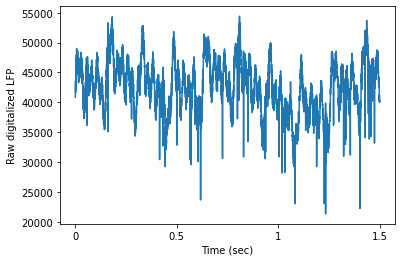

In [151]:
# visualize the trace
plt.plot(b[0][:30000])
plt.xticks([0,10000,20000,30000],[0,0.5,1,1.5])
plt.xlabel('Time (sec)')
plt.ylabel('Raw digitalized LFP')

## Step 1: Bandpass filter

In [6]:
# band pass filter: keep things that are within 300 and 3000 Hz
from scipy import signal

# use a Butterworth filter
sos = signal.butter(2, [300,3000], 'bandpass', fs=20000, output='sos') # second order sections
b_filt = np.zeros_like(b)
for i in range(4):
    b_filt[i] = signal.sosfilt(sos, b[i])
    b_filt[i][:50] = 0 # the first few samples are messy after band-pass filtering

Text(0, 0.5, 'BandPass LFP')

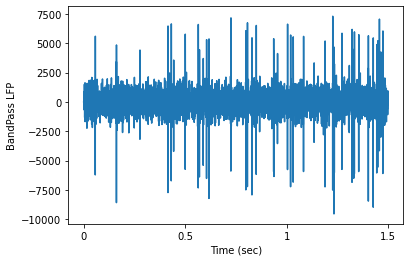

In [7]:
plt.plot(b_filt[0][:30000])
plt.xticks([0,10000,20000,30000],[0,0.5,1,1.5])
plt.xlabel('Time (sec)')
plt.ylabel('BandPass LFP')

$\textbf{Exercise}$ 1: compute the derivative of the LFP on the 4 channels (this is an alternative approach that is sometimes used instead of bandpass filtering)

## Step 2: detect spikes

In [8]:
# -> normalize the 4 lfp signals (individually) using robust statistics 
mad = np.median(np.abs(b_filt.T - np.median(b_filt,1)),0) #median absolute deviation
b_filt = (b_filt.T - np.median(b_filt,1)) / mad

In [10]:
# to detect spikes we follow these steps: 
# 1) sum the 4 normalized signals to amplify the spikes
b_sum = np.sum(b_filt,1)

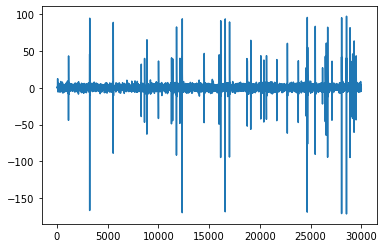

In [11]:
plt.plot(b_sum[:30000])

$\textbf{Exercise}$ 2: can you explain why summing the 4 signals will amplify spikes? Can you think of advantages and potentials problems with this approach?

In [12]:
# detect spikes: select local minima where signal is below threshold
spk = signal.find_peaks(-b_sum,height=20)

In [14]:
# number of spikes extracted
len(spk[0])

25108

In [15]:
# extract spike forms: take ~1ms either side of each spike
spks = [b_filt[s-21:s+23] for s in spk[0]]

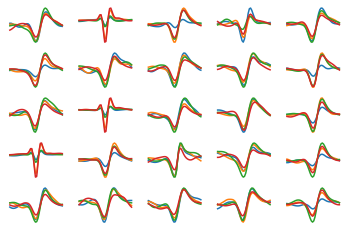

In [16]:
# visualize some of them
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(spks[i])
    plt.axis('off')

$\textbf{Exercise}$ 3: why are we detecting negative peaks? Play around with the threshold!

## Step 3: Feature extraction

In [17]:
# extract features using PCA
from sklearn.decomposition import PCA

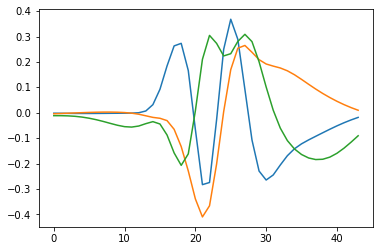

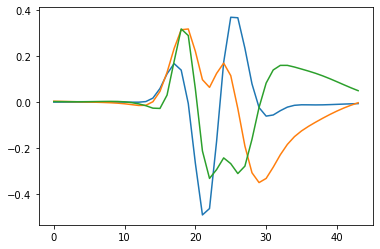

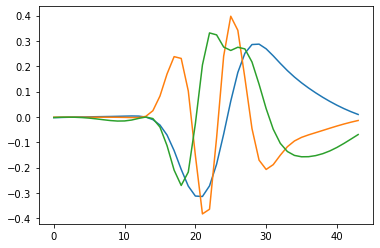

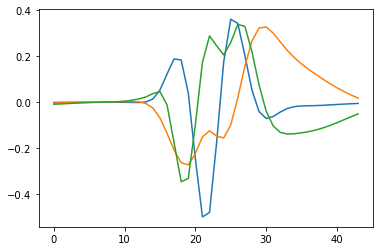

In [18]:
# do several things, separately for each channel: 
# 1) run PCA on the spike form extracted  on each channel
# 2) plot the first three components
# 3) save the first three features for each spike

X = []
for c in range(4):
    pca = PCA(n_components=3)    
    p = pca.fit([s[:,c] for s in spks])
    plt.plot(p.components_.T)
    plt.show()
    X.append(p.transform([s[:,c] for s in spks]))

# put the info regarding the first three features togehter in a single array
X = np.hstack(X)

$\textbf{Exercise}$ 4: use some other algorithm to extract features and compare them. In particular, try: 1) ICA 2) probabilistic PCA

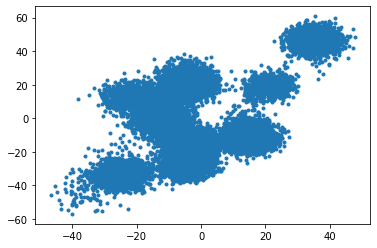

In [152]:
plt.scatter(X[:,1],X[:,10],marker='.')

$\textbf{Exercise}$ 5: look at the other projections. Which are the ones that allow you to "visually" discriminate clusters?

## Step 4: clustering

In [20]:
# the projections looks very "blobby" -> use gaussian mixtures for clustering
from sklearn.mixture import GaussianMixture

In [94]:
gm = GaussianMixture(n_components=11,random_state=4).fit(X) # random_state 4 for reproducibility
clu = gm.predict(X)

In [95]:
cols = np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan','yellow'])

In [96]:
# size of the clusters
[np.sum(clu==i) for i in range(10)]

[2678, 4318, 1234, 2686, 3002, 3329, 2467, 1507, 792, 2320]

In [97]:
# use TSNE (for visualization only!)
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=4)
Y = tsne.fit_transform(X)

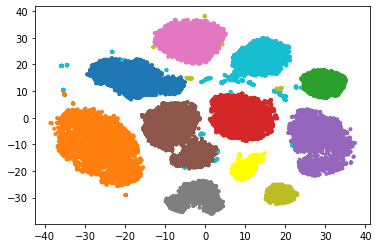

In [98]:
plt.scatter(Y[:,0], Y[:,1],marker='.',color=cols[clu])

$\textbf{Exercise}$ 6: notice that gaussian mixtures is NOT deterministic. Try some other clustering methods! Suggested read: "A novel automated spike sorting algorithm with adaptable feature extraction"

In [153]:
# save results
np.save('clus_res.npy',[spk[0],clu])

## Step 6: compare to ground thruth

In [45]:
# load ground truth
fir = np.load('fir.npy',allow_pickle=True)

In [47]:
# downsample detected spikes
spk_down = np.array(spk[0] / 20, dtype=int)

In [87]:
# check proportion of spikes detected
# allow for a small error in peak detection (+-1)
truth = np.sum(fir,0)>0
truth_er = np.convolve(np.sum(fir,0),np.ones(3),'same')>0
detec = np.zeros_like(truth)
detec[spk_down] = 1
detec_er = np.convolve(detec,np.ones(3),'same')>0

In [88]:
# proportion of detected spikes that are real spikes
np.mean(truth_er[spk_down])

0.9980882587223195

In [92]:
# proportion of real spikes that were detected
np.mean(detec_er[np.where(truth)[0]])

0.9708090379008746

Note: here we are not considering the fact that there could be bins with multiple spikes! Check out this paper for more information regarding the issue: "A Model-Based Spike Sorting Algorithm for Removing Correlation Artifacts in Multi-Neuron Recordings"

In [140]:
# check the goodness of the clustering
# if only one cell fired, call it that name. If more, call it 11
clu_tru = []
for i,s in enumerate(spk_down):
    f = fir[:,s]
    if np.sum(f) == 0: # allow for some "wiggle" in the detection
        f = fir[:,s-1]        
    if np.sum(f) == 1:
        clu_tru.append(np.where(f)[0][0])
    else:
        clu_tru.append(11)

In [118]:
from sklearn.metrics import homogeneity_score, completeness_score

In [141]:
homogeneity_score(clu_tru,clu)

0.8519919002070138

In [142]:
completeness_score(clu_tru,clu)

0.844084624947342